In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.t8btag_minmass

In [3]:
mx_list = np.array((700,800,900,1000,1200))

In [4]:
altfile='yy_quadh_bkg10_soft025_md_allsig_{base}'
# signal = ObjIter([ Tree(list(filter(lambda f,mx=mx : f'MX_{mx}' in f, module.full_signal_list)), altfile=altfile) for mx in mx_list ])
signal = ObjIter([ Tree(mx, altfile=altfile) for mx in module.full_signal_list ])


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


In [6]:
from utils.analysisUtils.eightb_analysis_v2 import eightb_analysis_v2
analysis = eightb_analysis_v2(
    signal=signal,
    sr_r=0.5, cr_r=1.0
)

In [8]:
analysis.run(runlist=['jet_kin_cuts'])

0:00:00 [running] reweight_bkg
0:00:00 [error] list index out of range

0:00:00 [running] jet_kin_cuts
0:00:00 [error] 'NoneType' object is not iterable

0:00:00 [skipping] plot_cutflow
0:00:00 [skipping] plot_ranker
0:00:00 [skipping] plot_t8btag_signal
0:00:00 [skipping] plot_eightb_signal
0:00:00 [skipping] plot_fully_reconstrcuted_id
0:00:00 [skipping] plot_global_jet_kin
0:00:00 [skipping] plot_assigned_jet_kin
0:00:00 [skipping] plot_assigned_higgs_kin
0:00:00 [skipping] plot_assigned_y_kin
0:00:00 [skipping] plot_x_kin
0:00:00 [skipping] plot_res_m
0:00:00 [skipping] build_higgs_rm
0:00:00 [skipping] plot_assigned_higgs_m
0:00:00 [skipping] plot_y_higgs_m
0:00:00 [skipping] plot_abcd_variables
0:00:00 [skipping] build_abcd
0:00:00 [skipping] plot_abcd_composition
0:00:00 [skipping] plot_abcd_regions
0:00:00 [skipping] plot_vr_datamc
0:00:00 [skipping] train_vr1_bdt
0:00:00 [skipping] train_vr2_bdt
0:00:00 [skipping] train_ar_bdt
0:00:00 [skipping] plot_ar_datamc
0:00:00 [skippin

In [5]:
for n in signal.apply(lambda t:np.sum(t.nfound_select==8)):
    print(n)

3138
3877
4208
4282
5192
4447
6061
8406


In [100]:
for sig in signal:
    for f in sig.filelist:
        # print(f.fname)
        print(Histo.from_th1d(f.histograms['h_cutflow_unweighted']).histo[-1])

43044.0
50121.0
51292.0
52492.0
56471.0
53618.0
60258.0
65170.0


In [118]:
# for m, s in signal.apply(lambda t : t.X_m).apply(get_avg_std):
for m, s in signal.apply(lambda t : t.X_m[t.nfound_select==8]).apply(get_avg_std):
    print (s)

79.45073552458997
96.87361721238656
96.53574735405006
102.56819061816599
117.92271349220127


In [17]:
for mx, sig in zip(mx_list, signal): 
    sig.sample = f'MX_{mx}'
    sig.mx_mass=mx

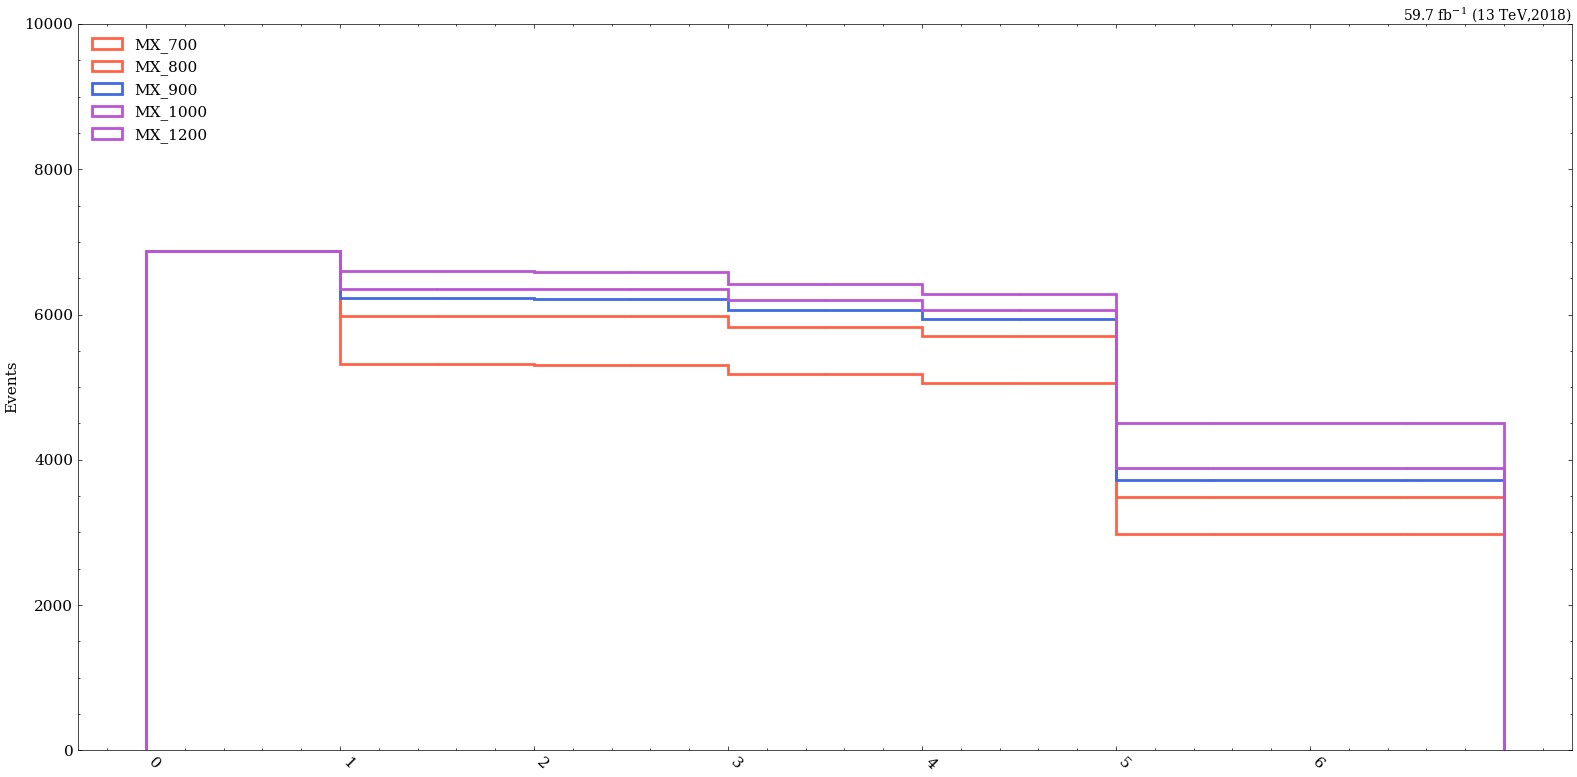

In [72]:
cutflow = obj_store()
study.cutflow(
    signal,
    legend=True,
    ylim=(0,1e4),
    log=False,
    store=cutflow
)
cutflow=cutflow[0]


In [73]:
mx_eff = ObjIter(cutflow).apply( lambda h : h.histo[-1]/h.histo[0] ).npy

In [74]:
mx_eff

array([0.43259847, 0.5078105 , 0.5422767 , 0.565154  , 0.6550033 ],
      dtype=float32)

$\tanh( 0.000664711148229992 * x )$


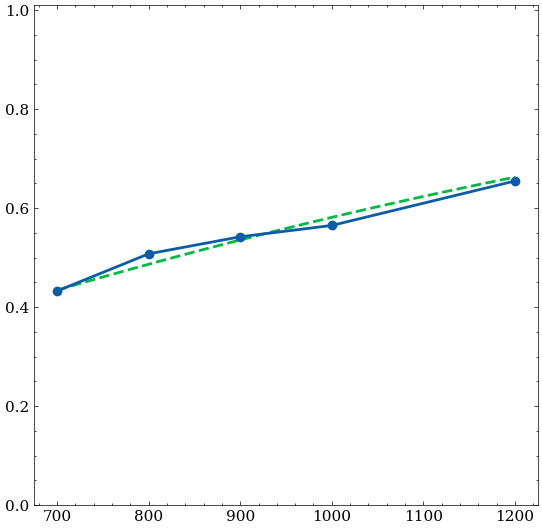

In [75]:
g_mx_eff = Graph(mx_list, mx_eff, fit='tanh')
plot_graph(g_mx_eff)
print(g_mx_eff.fit)

In [76]:
e_mx_list = np.array([4000,
           3500,
           3000,
           2800,
           2600,
           2500,
           2400,
           2200,
           2000,
           1900,
           1800,
           1700,
           1600,
           1500,
           1400,
           1300,
           1200,
           1100,
           1000,
           950,
           900,
           850,
           800,
           750,
           700,
           650,
           600,
           550,
           500,])


In [77]:
e_eff_list = g_mx_eff.fit.evaluate(e_mx_list)

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

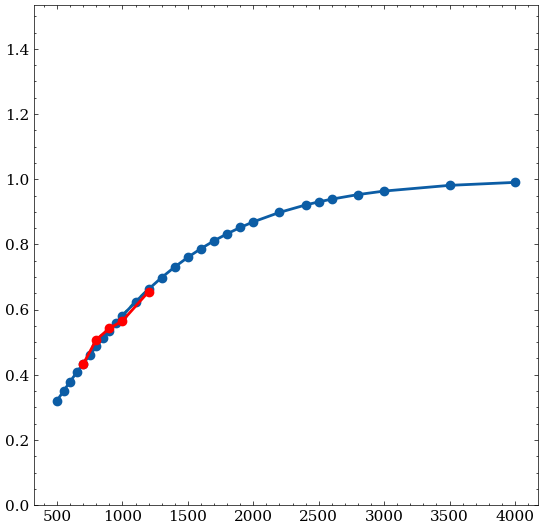

In [78]:
d_eff = g_mx_eff.set_attrs(color='red')
f_eff = Graph(e_mx_list, e_eff_list)
plot_graphs([f_eff, d_eff])

100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


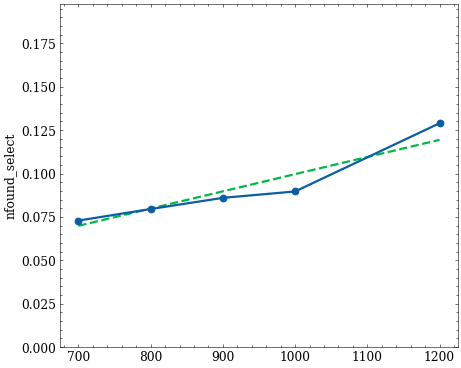

In [79]:
g_fully_res_eff = obj_store()
study.statsplot(
    signal,
    label=mx_list.tolist(),
    varlist=['nfound_select'],
    stat=lambda h : h.histo[-1]/np.sum(h.histo),

    g_g_fit='tanh',
    g_exe=lambda graph, *args, **kwargs: g_fully_res_eff.append(graph),
)
g_fully_res_eff = g_fully_res_eff[0]

In [80]:
e_fully_res_eff_list = g_fully_res_eff.fit.evaluate(e_mx_list)

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

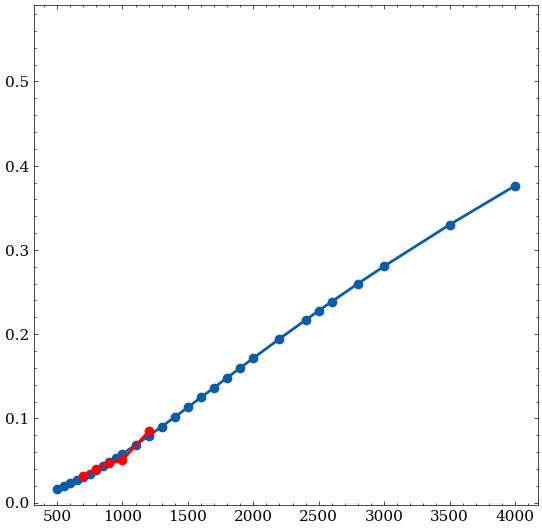

In [84]:
d_fully_res_eff = g_fully_res_eff.set_attrs(color='red') * d_eff
f_fully_res_eff = Graph(e_mx_list, e_fully_res_eff_list) * f_eff
plot_graphs([f_fully_res_eff, d_fully_res_eff])